In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [2]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true[:,3]-y_pred[:,3])))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return np.mean((y_true[1:,3]-y_true[:-1,3])*mask)

In [3]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [4]:
def createDataset(dataset, look_back, n_features):
    dataX = np.zeros([len(dataset)-look_back, look_back, n_features])
    dataY = np.zeros([len(dataset)-look_back, n_features])
    data = dataset.drop(columns='Date').to_numpy()
    print(data.shape)
    for i in range(0, len(data)-look_back):
        dataX[i] = data[i:i+look_back]
        dataY[i] = data[i+look_back]
    mean = dataX.mean(axis=1)
    std = dataX.std(axis=1)
    dataX = (dataX - mean[:,None,:])/std[:,None,:]
    dataY = (dataY - mean)/std
    return dataX, dataY, mean, std
def plot_frame(sequence, target, mean, std, model):
    y_pred = model.predict(sequence)
    y_pred_real = y_pred*std + mean
    y_true = target
    y_true_real = y_true*std + mean
    
    plt.figure()
    plt.title("closing price")
    plt.plot(y_true_real[...,3], label="true")
    plt.plot(y_pred_real[...,3], label="prediction")
    plt.legend()
    plt.show()
    return y_pred_real, y_true_real

In [5]:
look_back=5
n_sequence = look_back
n_features = 7
stock_code = "AAPL"
start = dt.datetime(2021, 1, 1)
end = dt.datetime(2021, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end)
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, look_back)
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,2021-01-11,129.190002,130.169998,128.500000,128.979996,127.079964,100384500,129.998000
6,2021-01-12,128.500000,129.690002,126.860001,128.800003,126.902626,91951100,129.911998
7,2021-01-13,128.759995,131.449997,128.490005,130.889999,128.961838,88636800,129.470000
8,2021-01-14,130.800003,131.000000,128.759995,128.910004,127.011002,90221800,130.328000
9,2021-01-15,128.779999,130.220001,127.000000,127.139999,125.267075,111598500,129.926001
...,...,...,...,...,...,...,...,...
246,2021-12-23,175.850006,176.850006,175.270004,176.279999,174.753906,68356600,172.356000
247,2021-12-27,177.089996,180.419998,177.070007,180.330002,178.768860,74919600,173.160001
248,2021-12-28,180.160004,181.330002,178.529999,179.289993,177.737854,79144300,174.998001
249,2021-12-29,179.330002,180.630005,178.139999,179.380005,177.827057,62348900,176.906000


In [6]:
x, y, mean, std = createDataset(df, look_back, n_features)
generator = keras.models.load_model("rnn.h5", custom_objects={"mse": mse , "mae": mae, "mape": mape, "rmse": rmse, "ar": ar})

(246, 7)


8/8 [==============================] - 0s 2ms/step


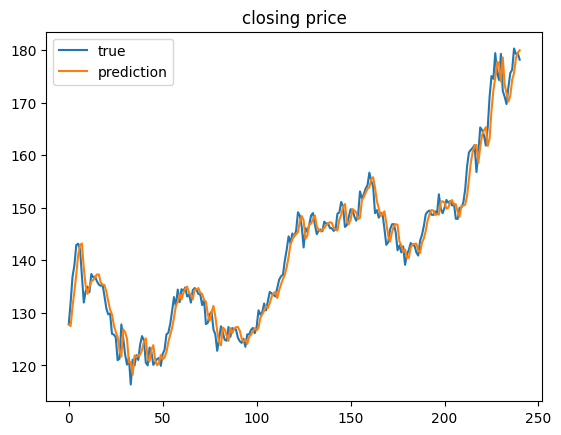

In [7]:
y_pred = generator.predict(x)
y_pred_real = y_pred*std + mean
y_true = y
y_true_real = y_true*std + mean

plt.figure()
plt.title("closing price")
plt.plot(y_true_real[...,3], label="true")
plt.plot(y_pred_real[...,3], label="prediction")
plt.legend()
plt.show()

In [8]:
print(mse(y_true_real, y_pred_real))
print(mae(y_true_real, y_pred_real))
print(mape(y_true_real, y_pred_real))
print(rmse(y_true_real, y_pred_real))
print(ar(y_true_real, y_pred_real))

6.068703687066995
1.8801424574623438
0.013307474947697417
2.463473906309339
0.065458104


In [9]:
y_pred_real.shape

(241, 7)

In [10]:
df.shape

(246, 8)

In [11]:
# cột: tên metric
# Dòng: Tên files
table = []
models_files = ['dcbilstm_ffnn_5.h5', 'lstm.h5', 'gru.h5', 'dcbilstm.h5', 'bilstm.h5', 'rnn.h5']
for model_file in models_files:
    look_back=5
    n_sequence = look_back
    n_features = 7
    stock_code = "AAPL"
    start = dt.datetime(2021, 1, 1)
    end = dt.datetime(2021, 12, 31)
    raw_data = pdr.get_data_yahoo(stock_code, start, end)
    df = raw_data.dropna();
    df = df.reset_index(level=0)
    df = add_Ma(df, look_back)
    
    x, y, mean, std = createDataset(df, look_back, n_features)
    generator = keras.models.load_model(model_file, custom_objects={"mse": mse , "mae": mae, "mape": mape, "rmse": rmse, "ar": ar})
    
    y_pred = generator.predict(x)
    y_pred_real = y_pred*std + mean
    y_true = y
    y_true_real = y_true*std + mean
    
    row = [mse(y_true_real, y_pred_real), mae(y_true_real, y_pred_real), mape(y_true_real, y_pred_real), rmse(y_true_real, y_pred_real)]
    table.append(row)
result = pd.DataFrame(table, index=models_files, columns=['mse', 'mae', 'mape', 'rmse'])
result

[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 0s 2ms/step
[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 0s 2ms/step
[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 0s 2ms/step
[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 0s 1ms/step
[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 1s 4ms/step
[*********************100%***********************]  1 of 1 completed
(246, 7)
8/8 [==============================] - 0s 2ms/step


,mse,mae,mape,rmse
dcbilstm_ffnn_5.h5,5.239003,1.808994,0.012825,2.288887
lstm.h5,6.183977,1.893580,0.013448,2.486760
gru.h5,5.710591,1.795904,0.012784,2.389684
dcbilstm.h5,5.747632,1.819110,0.012865,2.397422
bilstm.h5,5.933614,1.844392,0.013086,2.435901
rnn.h5,6.068705,1.880142,0.013307,2.463474
